In [ ]:
!pip install yfinance --upgrade --no-cache-dir

In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

#NVIDIA

In [ ]:
ticker = yf.Ticker('NVDA')
dfNVDA = ticker.history(period='5y')

In [ ]:
dates = dfNVDA.index.to_numpy()
high_prices = dfNVDA['High'].to_numpy()

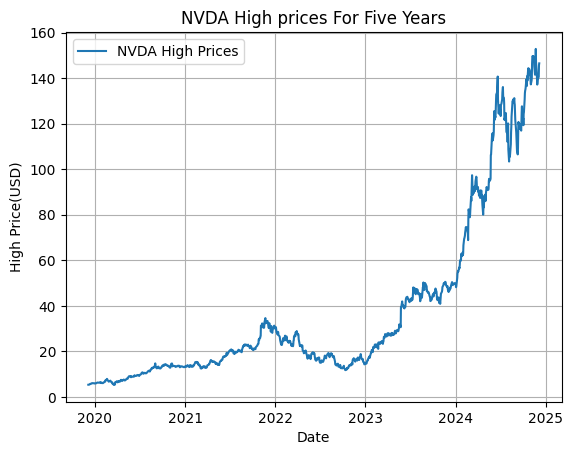

In [ ]:
plt.plot(dates, high_prices, label='NVDA High Prices')
plt.title('NVDA High prices For Five Years')
plt.xlabel('Date')
plt.ylabel('High Price(USD)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
result = adfuller(dfNVDA['High'])
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('\nCritical Values:')
for key, value in critical_values.items():
    print(f' {key}:{value}')

ADF Statistic: 1.7854311573350148
p-value: 0.9983196801538623

Critical Values:
 1%:-3.4355671297788666
 5%:-2.8638438984080117
 10%:-2.5679966213893057


<Axes: ylabel='Density'>

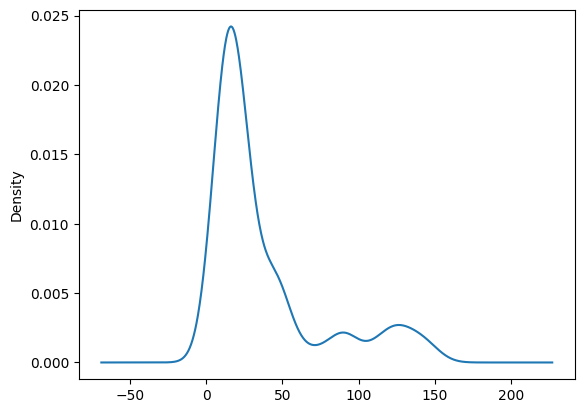

In [ ]:
dfNVDA['High'].plot(kind='kde')

<Figure size 3000x900 with 0 Axes>

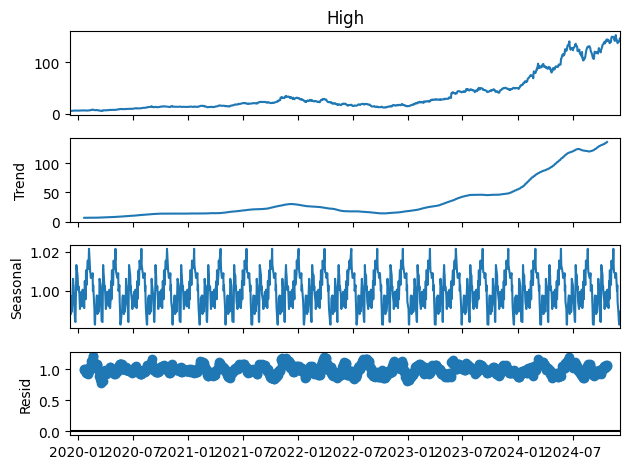

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

#Seasonal decomposition using 'multiplicative' model and a period of 30 days
result = seasonal_decompose(dfNVDA['High'], model='multiplicative', period=60)

#Plotting the result
plt.figure(figsize=(30, 9))
result.plot()
plt.show()

In [ ]:
rolling_mean = dfNVDA['High'].rolling(window=30).mean()
rolling_std = dfNVDA['High'].rolling(window=30).std()

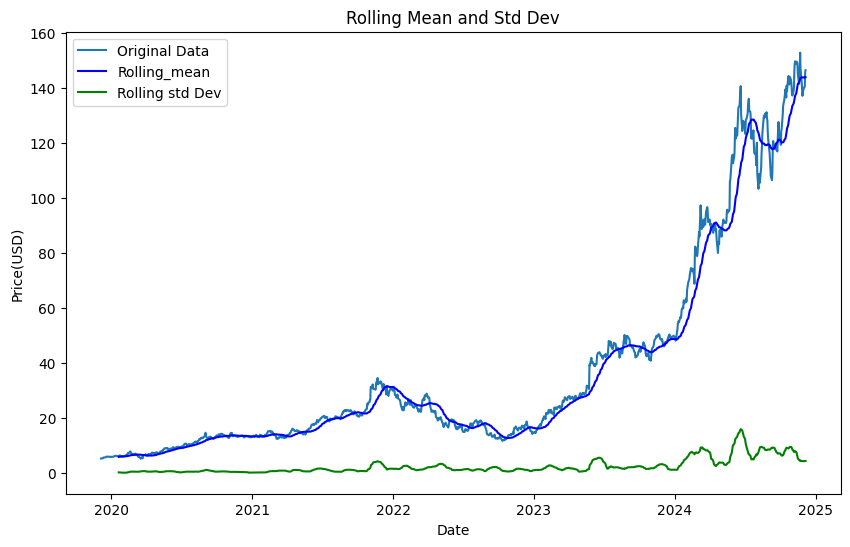

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dfNVDA['High'], label='Original Data')
plt.plot(rolling_mean, label='Rolling_mean', color='blue')
plt.plot(rolling_std, label='Rolling std Dev', color='green')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.title("Rolling Mean and Std Dev")
plt.show()

In [ ]:
dfNVDA['diff'] = dfNVDA['High'].diff()

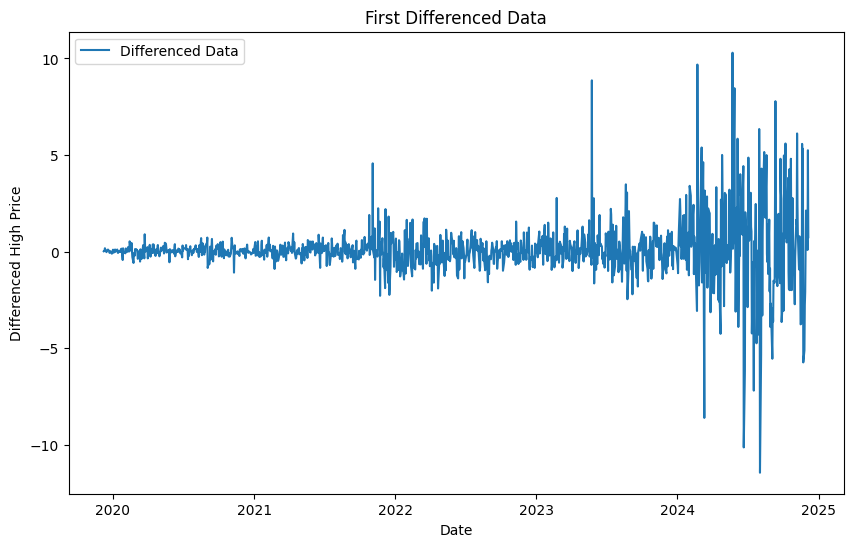

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dfNVDA['diff'], label='Differenced Data')
plt.title('First Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced High Price')
plt.legend()
plt.show()

In [ ]:
adf_result_diff = adfuller(dfNVDA['diff'].dropna())

In [ ]:
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"{key}: {value}")

ADF Statistic: -31.6827574388165
p-value: 0.0
Critical Values:
1%: -3.4355671297788666
5%: -2.8638438984080117
10%: -2.5679966213893057


In [ ]:
train_size = int(len(high_prices) * 0.9)
train = high_prices[:train_size]
test = high_prices[train_size:]


train_dates = dates[:train_size]
test_dates = dates[train_size:]

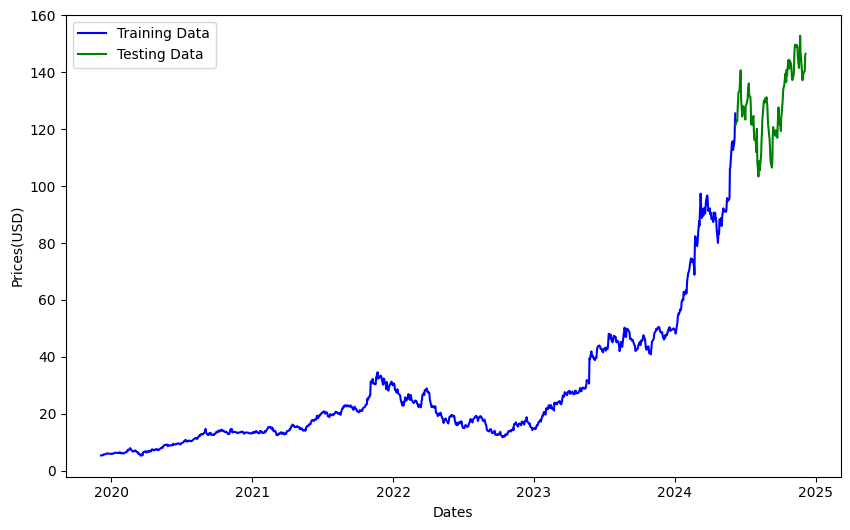

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train, label='Training Data', color='blue')
plt.plot(test_dates, test, label='Testing Data', color='green')
plt.xlabel('Dates')
plt.ylabel('Prices(USD)')
plt.legend()
plt.show()

In [ ]:
log_train = np.log(train)
log_test = np.log(test)

In [ ]:
auto_model = auto_arima(log_train, seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4805.649, Time=4.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4809.951, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4811.577, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4811.509, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4801.346, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4809.645, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4809.632, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4807.640, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4804.180, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 7.941 seconds


In [ ]:
forecast_steps = len(log_test)
forecast_log ,conf_int = auto_model.predict(n_periods=forecast_steps,return_conf_int=True )

In [ ]:
forecast = np.exp(forecast_log)

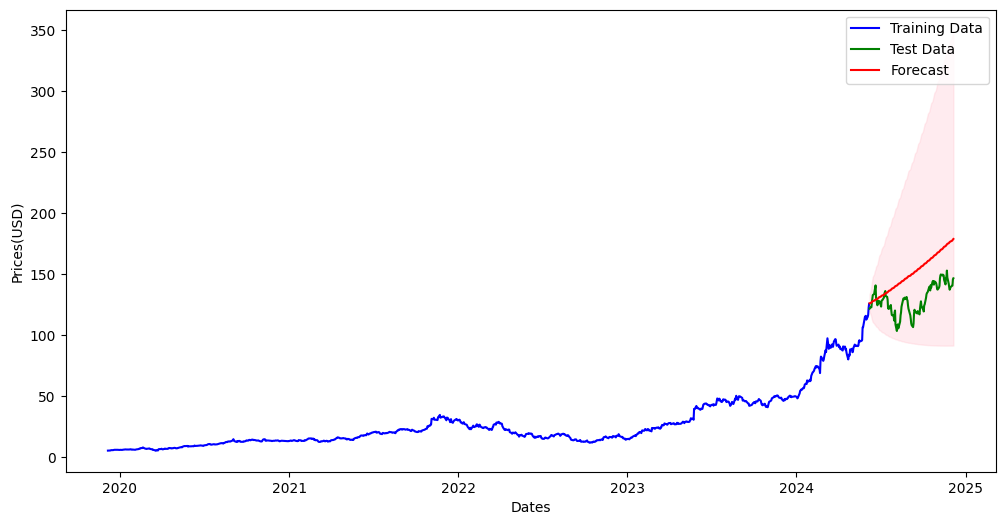

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train, label='Training Data', color='blue')
plt.plot(test_dates, test, label='Test Data', color='green')
plt.plot(test_dates, forecast, label='Forecast', color='red')

plt.fill_between(test_dates, np.exp(conf_int[:, 0]), np.exp(conf_int[:, 1]), color='pink', alpha=0.3)

plt.xlabel('Dates')
plt.ylabel('Prices(USD)')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test))  # less than 10% = exellent, 10-20% = good, greater than 20% = not good
print(f'(MAE) on Test Data: {mae:2f}')
print(f'(MSE) on Test Data: {mse:2f}')
print(f'(RMSE) on Test Data: {rmse:2f}')
print(f'(MAPE) on Test Data: {mape:2f}')

(MAE) on Test Data: 22.348114
(MSE) on Test Data: 633.487046
(RMSE) on Test Data: 25.169169
(MAPE) on Test Data: 0.176637


Future Forecast

In [ ]:
log_high_prices = np.log(high_prices)

In [ ]:
auto_model = auto_arima(log_high_prices, seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5362.036, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5363.971, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5368.040, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5368.026, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5355.320, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5366.043, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5366.042, Time=1.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5364.031, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5360.842, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 3.970 seconds


In [ ]:
forecast_steps_n = 100
forecast_log_n, conf_int_n = auto_model.predict(n_periods=forecast_steps_n, return_conf_int=True)

In [ ]:
forecast_n = np.exp(forecast_log_n)
last_date = dates[-1]
forecast_dates_n = pd.date_range(start=last_date, periods=forecast_steps_n + 1, freq='B')[1:]
forecast_dates_n = np.array(forecast_dates_n)

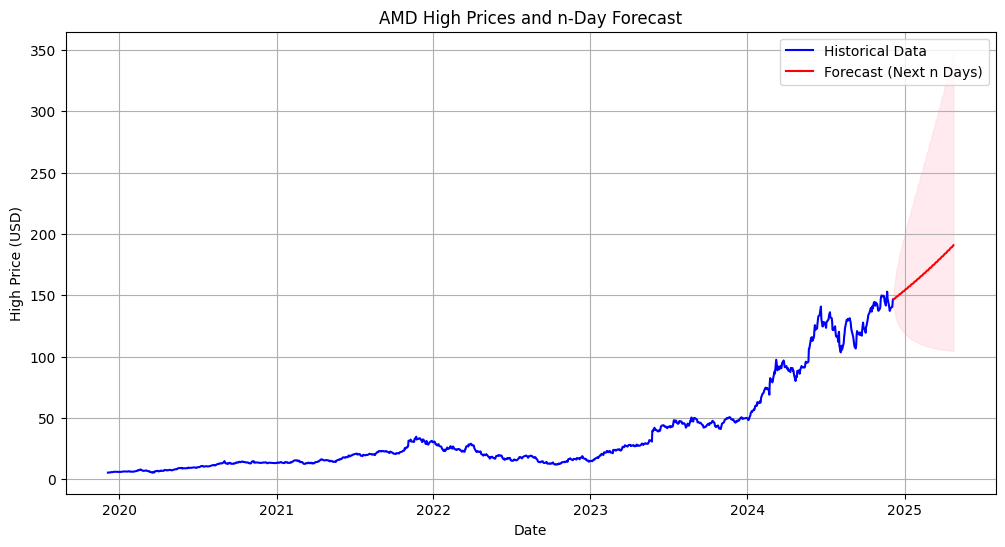

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dates, high_prices, label='Historical Data', color='blue')
plt.plot(forecast_dates_n, forecast_n, label='Forecast (Next n Days)', color='red')
plt.fill_between(forecast_dates_n, np.exp(conf_int_n[:, 0]), np.exp(conf_int_n[:, 1]), color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('High Price (USD)')
plt.title('AMD High Prices and n-Day Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast_df_n = pd.DataFrame({'Date': forecast_dates_n, 'Predicted Price': forecast_n})
print(forecast_df_n)

                        Date  Predicted Price
0  2024-12-06 00:00:00-05:00       146.952183
1  2024-12-09 00:00:00-05:00       147.341772
2  2024-12-10 00:00:00-05:00       147.730739
3  2024-12-11 00:00:00-05:00       148.120618
4  2024-12-12 00:00:00-05:00       148.511518
..                       ...              ...
95 2025-04-18 00:00:00-04:00       188.764609
96 2025-04-21 00:00:00-04:00       189.262770
97 2025-04-22 00:00:00-04:00       189.762246
98 2025-04-23 00:00:00-04:00       190.263040
99 2025-04-24 00:00:00-04:00       190.765156

[100 rows x 2 columns]


#AMD


In [ ]:
ticker = yf.Ticker('AMD')
dfamd = ticker.history(period='5y')

In [ ]:
dates = dfamd.index.to_numpy()
high_prices = dfamd['High'].to_numpy()

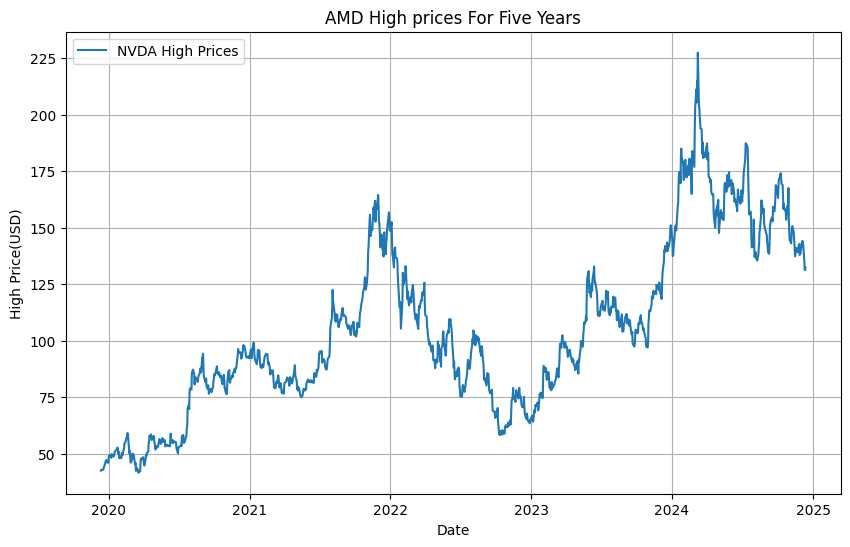

In [ ]:
plt.plot(dates, high_prices, label='NVDA High Prices')
plt.title('AMD High prices For Five Years')
plt.xlabel('Date')
plt.ylabel('High Price(USD)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
result = adfuller(dfamd['High'])
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('\nCritical Values:')
for key, value in critical_values.items():
    print(f' {key}:{value}')

ADF Statistic: -1.9921436531519447
p-value: 0.2900284223406591

Critical Values:
 1%:-3.4355629707955395
 5%:-2.863842063387667
 10%:-2.567995644141416


<Axes: ylabel='Density'>

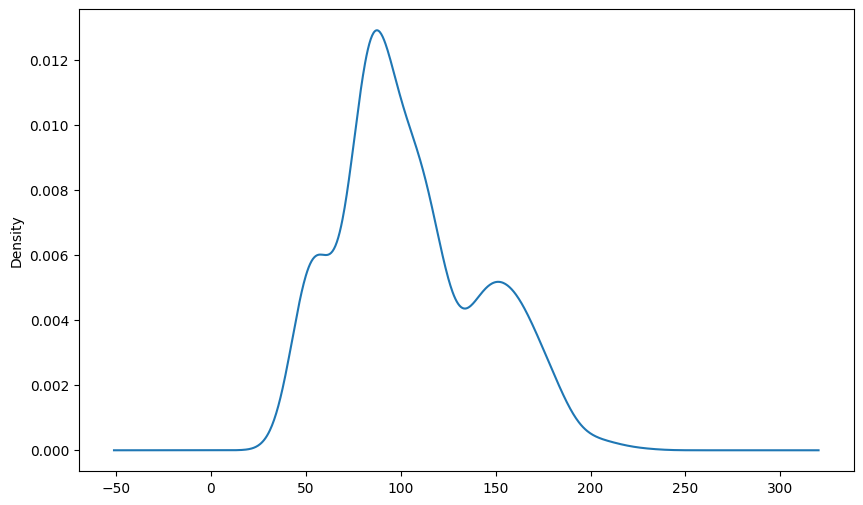

In [ ]:
dfamd['High'].plot(kind='kde')

<Figure size 3000x900 with 0 Axes>

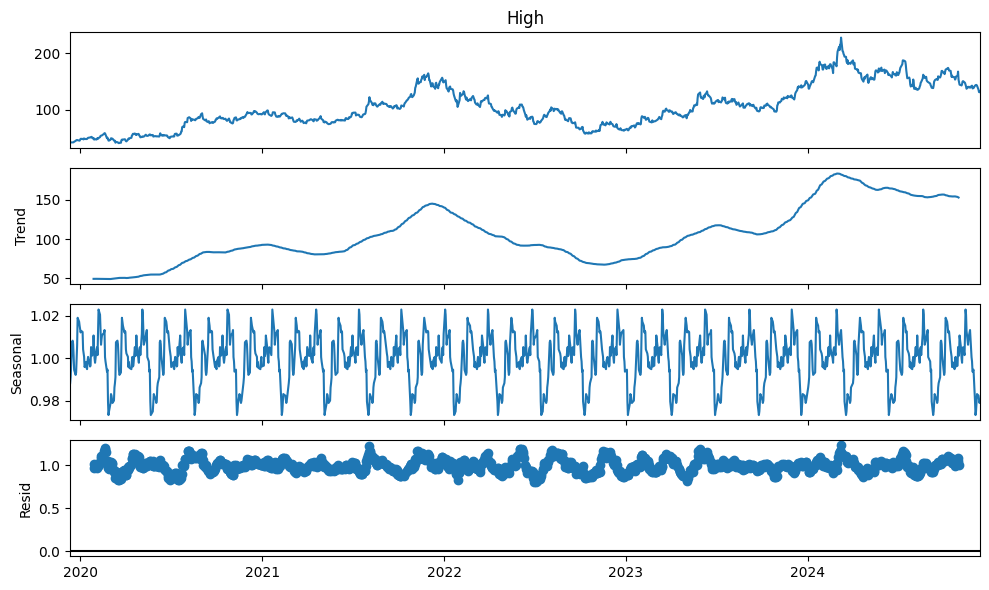

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

#Seasonal decomposition using 'multiplicative' model and a period of 30 days
result = seasonal_decompose(dfamd['High'], model='multiplicative', period=60)

#Plotting the result
plt.figure(figsize=(30, 9))
result.plot()
plt.show()

In [ ]:
rolling_mean = dfamd['High'].rolling(window=30).mean()
rolling_std = dfamd['High'].rolling(window=30).std()

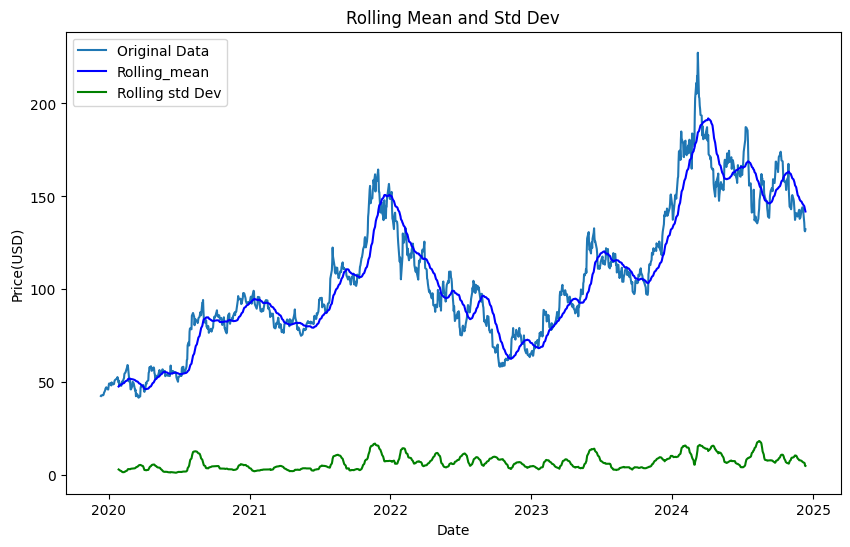

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dfamd['High'], label='Original Data')
plt.plot(rolling_mean, label='Rolling_mean', color='blue')
plt.plot(rolling_std, label='Rolling std Dev', color='green')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.title("Rolling Mean and Std Dev")
plt.show()

In [ ]:
dfamd['diff'] = dfamd['High'].diff()

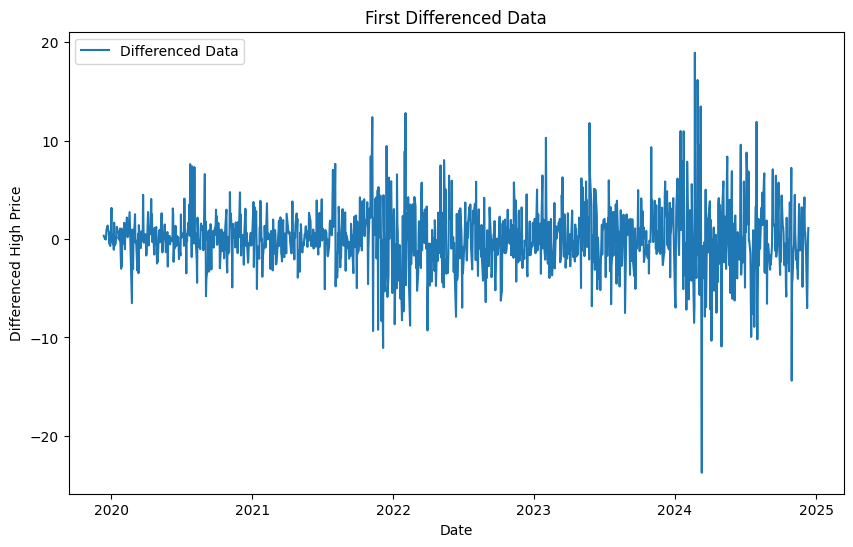

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(dfamd['diff'], label='Differenced Data')
plt.title('First Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced High Price')
plt.legend()
plt.show()

In [ ]:
adf_result_diff = adfuller(dfamd['diff'].dropna())

In [ ]:
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"{key}: {value}")

ADF Statistic: -33.079236438174526
p-value: 0.0
Critical Values:
1%: -3.4355629707955395
5%: -2.863842063387667
10%: -2.567995644141416


In [ ]:
train_size = int(len(high_prices) * 0.9)
train = high_prices[:train_size]
test = high_prices[train_size:]


train_dates = dates[:train_size]
test_dates = dates[train_size:]

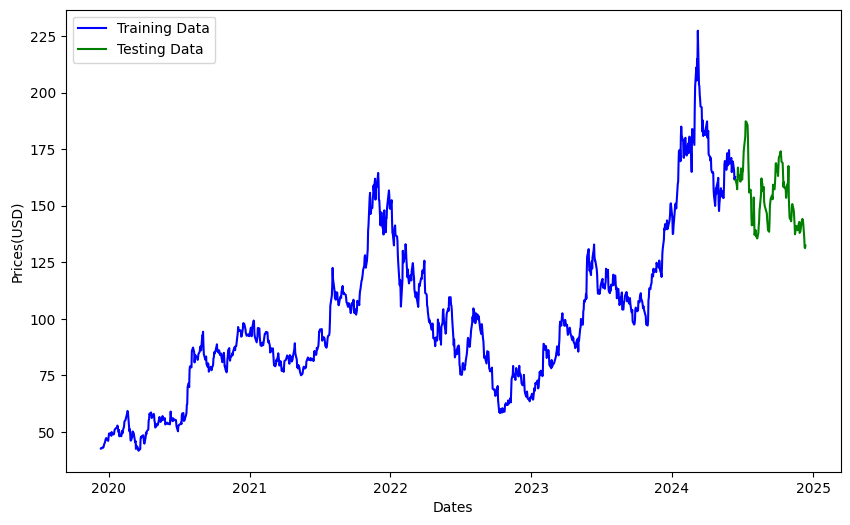

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_dates, train, label='Training Data', color='blue')
plt.plot(test_dates, test, label='Testing Data', color='green')
plt.xlabel('Dates')
plt.ylabel('Prices(USD)')
plt.legend()
plt.show()

In [ ]:
log_train = np.log(train)
log_test = np.log(test)

In [ ]:
auto_model = auto_arima(log_train, seasonal=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4818.610, Time=1.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4816.023, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4823.908, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4823.743, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4816.112, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4821.912, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4821.911, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4819.919, Time=1.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4824.323, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4822.336, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4822.331, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4824.125, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4820.345, Time=0.38 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 5.481 seconds


In [ ]:
forecast_steps_n = 100
forecast_log_n, conf_int_n = auto_model.predict(n_periods=forecast_steps_n, return_conf_int=True)

In [ ]:
forecast_n = np.exp(forecast_log_n)
last_date = dates[-1]
forecast_dates_n = pd.date_range(start=last_date, periods=forecast_steps_n + 1, freq='B')[1:]
forecast_dates_n = np.array(forecast_dates_n)

In [ ]:
forecast = np.exp(forecast_log)

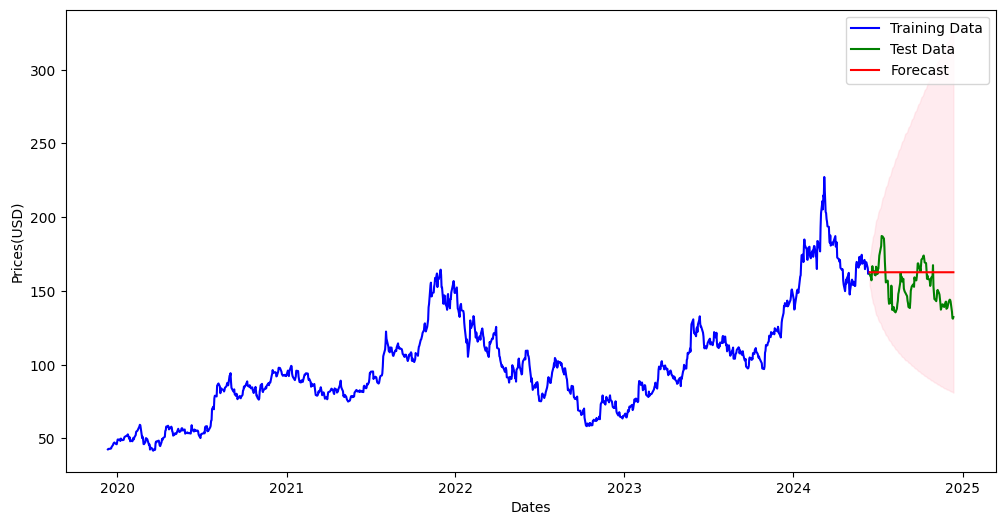

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_dates, train, label='Training Data', color='blue')
plt.plot(test_dates, test, label='Test Data', color='green')
plt.plot(test_dates, forecast, label='Forecast', color='red')

plt.fill_between(test_dates, np.exp(conf_int[:, 0]), np.exp(conf_int[:, 1]), color='pink', alpha=0.3)

plt.xlabel('Dates')
plt.ylabel('Prices(USD)')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - forecast) / test))  # less than 10% = exellent, 10-20% = good, greater than 20% = not good
print(f'(MAE) on Test Data: {mae:2f}')
print(f'(MSE) on Test Data: {mse:2f}')
print(f'(RMSE) on Test Data: {rmse:2f}')
print(f'(MAPE) on Test Data: {mape:2f}')

(MAE) on Test Data: 12.890052
(MSE) on Test Data: 240.391374
(RMSE) on Test Data: 15.504560
(MAPE) on Test Data: 0.087201


In [ ]:
forecast_df_n = pd.DataFrame({'Date': forecast_dates_n, 'Predicted Price': forecast_n})
print(forecast_df_n)

                        Date  Predicted Price
0  2024-12-13 00:00:00-05:00       162.699875
1  2024-12-16 00:00:00-05:00       162.703656
2  2024-12-17 00:00:00-05:00       162.704014
3  2024-12-18 00:00:00-05:00       162.704048
4  2024-12-19 00:00:00-05:00       162.704051
..                       ...              ...
95 2025-04-25 00:00:00-04:00       162.704052
96 2025-04-28 00:00:00-04:00       162.704052
97 2025-04-29 00:00:00-04:00       162.704052
98 2025-04-30 00:00:00-04:00       162.704052
99 2025-05-01 00:00:00-04:00       162.704052

[100 rows x 2 columns]


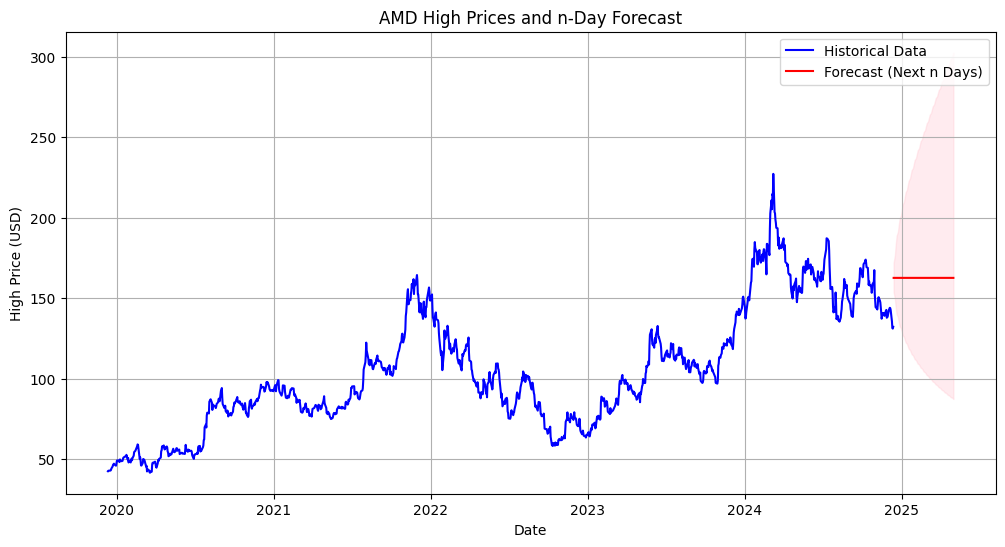

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dates, high_prices, label='Historical Data', color='blue')
plt.plot(forecast_dates_n, forecast_n, label='Forecast (Next n Days)', color='red')
plt.fill_between(forecast_dates_n, np.exp(conf_int_n[:, 0]), np.exp(conf_int_n[:, 1]), color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('High Price (USD)')
plt.title('AMD High Prices and n-Day Forecast')
plt.legend()
plt.grid(True)
plt.show()